# Samsara TSP Data Quality Assessment (SS, Oct 2021)

In [212]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import getpass
import psycopg2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import gzip
import json
# from tqdm import tqdm
import seaborn as sns

In [213]:
# Define a function to ingest JSON that have multple objects on the same row
def json_load_all(buf):
    while True:
        try:
            yield json.loads(buf)
        except json.JSONDecodeError as err:
            yield json.loads(buf[:err.pos])
            buf = buf[err.pos:]
        else:
            break

# 1. Samsara

## 1.1 Safety Events

In [214]:
# Get safety events
safety_events_data_path = '/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events'
safety_events_data_files = [os.path.join(dirpath,filename) for dirpath, _, filenames in os.walk(safety_events_data_path) for filename in filenames if 'DS_Store' not in filename]

In [215]:
# safety_events_data_files

In [216]:
# Import files
safety_events_data_list = []
counter = 0
for file in safety_events_data_files:
    print(file)
    with gzip.open(file, 'r') as fin:
        data_raw = fin.read().decode('utf-8')
        
        if data_raw == '':
            pass
        else:
            arr = list(json_load_all(data_raw))
            counter += len(arr)
            safety_events_data_list = safety_events_data_list + arr

/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/03/200f639c-5293-4ba0-9e7a-335fc2169317
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/04/8d921fd4-ae0d-42a8-b338-a476dba47dde
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/05/36988571-e015-4411-8999-08b722a41bd8
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/02/611d5bca-96db-4243-9580-15703729def1
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/02/3d874a37-9511-4897-b8ba-be38f650b48b
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/10/21584fe0-cdda-4983-ad2c-60e29805dbc4
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/safety-events/2021/10/07/49816b10-697d-472f-bdcd-5106e1b4bd3d
/Users/sven.sabas/projects/tsp-evaluation-framework/data/sourc

In [217]:
# Put to dataframe
safety_events_data_df = pd.io.json.json_normalize(safety_events_data_list, sep='_')

/var/folders/vn/5qd8cddx42ng5dz9pxrkw23m0000gy/T/ipykernel_38598/3098423538.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  safety_events_data_df = pd.io.json.json_normalize(safety_events_data_list, sep='_')


In [218]:
safety_events_data_df

,id,time,maxAccelerationGForce,downloadInwardVideoUrl,coachingState,behaviorLabels,vehicle_id,vehicle_name,location_latitude,location_longitude,...,driver_safetyScoreRank,driver_totalDistanceDrivenMeters,driver_totalTimeDrivenMs,driver_timeOverSpeedLimitMs,driver_totalHarshEventCount,driver_harshEvents,driver_harshBrakingCount,driver_harshAccelCount,driver_harshTurningCount,driver_crashCount
0,844424930142175-1633280759049,2021-10-03T17:05:59.049Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'genericDistraction', 'source': 'au...",844424930142175,PJ20 TGY,53.629243,-2.709615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,844424930142176-1633274476524,2021-10-03T15:21:16.524Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'forwardCollisionWarning', 'source'...",844424930142176,PJ20 NDL,53.588840,-2.683099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,844424930155837-1633267080514,2021-10-03T13:18:00.514Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'genericDistraction', 'source': 'au...",844424930155837,PJ20 TGX,53.537633,-2.696961,...,2,45432.0,5783976.0,103991.0,0.0,[],0.0,0.0,0.0,0.0
3,844424930155837-1633267080514,2021-10-03T13:18:00.514Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'genericDistraction', 'source': 'au...",844424930155837,PJ20 TGX,53.537633,-2.696961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,844424930183200-1633264521834,2021-10-03T12:35:21.834Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'forwardCollisionWarning', 'source'...",844424930183200,PJ20 YTS,53.731468,-2.686403,...,1,0.0,0.0,0.0,0.0,[],0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,844424930142181-1632982279741,2021-09-30T06:11:19.741Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'followingDistance', 'source': 'aut...",844424930142181,PJ20 TBX,53.542421,-2.808385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1187,844424930142181-1632982003072,2021-09-30T06:06:43.072Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'followingDistance', 'source': 'aut...",844424930142181,PJ20 TBX,53.502957,-2.924529,...,1,0.0,0.0,0.0,0.0,[],0.0,0.0,0.0,0.0
1188,844424930142181-1632982003072,2021-09-30T06:06:43.072Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'followingDistance', 'source': 'aut...",844424930142181,PJ20 TBX,53.502957,-2.924529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1189,844424930142181-1632981773229,2021-09-30T06:02:53.229Z,0.0,https://s3.eu.samsara.com/samsara-eu-dashcam-v...,dismissed,"[{'label': 'followingDistance', 'source': 'aut...",844424930142181,PJ20 TBX,53.483561,-2.917432,...,1,0.0,0.0,0.0,0.0,[],0.0,0.0,0.0,0.0


In [219]:
safety_events_data_df.columns

Index(['id', 'time', 'maxAccelerationGForce', 'downloadInwardVideoUrl',
       'coachingState', 'behaviorLabels', 'vehicle_id', 'vehicle_name',
       'location_latitude', 'location_longitude', 'downloadForwardVideoUrl',
       'driver_id', 'driver_name', 'driver_driverId', 'driver_safetyScore',
       'driver_safetyScoreRank', 'driver_totalDistanceDrivenMeters',
       'driver_totalTimeDrivenMs', 'driver_timeOverSpeedLimitMs',
       'driver_totalHarshEventCount', 'driver_harshEvents',
       'driver_harshBrakingCount', 'driver_harshAccelCount',
       'driver_harshTurningCount', 'driver_crashCount'],
      dtype='object')

In [220]:
# Parse dates
safety_events_data_df['time'] = pd.to_datetime(safety_events_data_df.time)

In [221]:
len(safety_events_data_df.vehicle_name.value_counts())

19

In [222]:
# Daterange
print(f'Min date {safety_events_data_df.time.min()}, \
      \nMax date {safety_events_data_df.time.max()}, \
      \nDate range {safety_events_data_df.time.max() - safety_events_data_df.time.min()}')

Min date 2021-09-06 07:38:27.381000+00:00,       
Max date 2021-10-10 15:03:27.474000+00:00,       
Date range 34 days 07:25:00.093000


In [223]:
safety_events_data_df.behaviorLabels.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[{'label': 'followingDistance', 'source': 'automated'}]          556
[{'label': 'forwardCollisionWarning', 'source': 'automated'}]    447
[{'label': 'genericDistraction', 'source': 'automated'}]         147
[{'label': 'braking', 'source': 'automated'}]                     25
[{'label': 'obstructedCamera', 'source': 'automated'}]            16
Name: behaviorLabels, dtype: int64

In [224]:
safety_events_data_df.driver_totalHarshEventCount.value_counts()

0.0    565
1.0      7
3.0      1
Name: driver_totalHarshEventCount, dtype: int64

In [225]:
safety_events_data_df.driver_harshBrakingCount.value_counts()

0.0    565
1.0      7
3.0      1
Name: driver_harshBrakingCount, dtype: int64

In [226]:
safety_events_data_df.driver_harshAccelCount.value_counts()

0.0    573
Name: driver_harshAccelCount, dtype: int64

In [227]:
safety_events_data_df.driver_harshEvents.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                                                                                                                                                                                                                                                               565
[{'vehicleId': 844424930143556, 'timestampMs': 1633522577421, 'harshEventType': 'Harsh Event'}]                                                                                                                                                                                                    2
[{'vehicleId': 844424930142917, 'timestampMs': 1632333237026, 'harshEventType': 'Harsh Event'}]                                                                                                                                                                                                    1
[{'vehicleId': 844424930142917, 'timestampMs': 1632331105134, 'harshEventType': 'Harsh Brake'}, {'vehicleId': 84442493014

In [228]:
safety_events_data_df[safety_events_data_df['id'] == '844424930142916-1631796430981'].loc[653]

id                                                      844424930142916-1631796430981
time                                                 2021-09-16 12:47:10.981000+00:00
maxAccelerationGForce                                                        0.911223
downloadInwardVideoUrl              https://s3.eu.samsara.com/samsara-eu-dashcam-v...
coachingState                                                             needsReview
behaviorLabels                          [{'label': 'braking', 'source': 'automated'}]
vehicle_id                                                            844424930142916
vehicle_name                                                                 PJ20 MYN
location_latitude                                                           53.644292
location_longitude                                                          -2.622092
downloadForwardVideoUrl             https://s3.eu.samsara.com/samsara-eu-dashcam-v...
driver_id                                             

## 1.2 Vehicle Stats

In [229]:
# Vehicle stats
vehicle_stats_data_path = '/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats'
vehicle_stats_data_files = [os.path.join(dirpath,filename) for dirpath, _, filenames in os.walk(vehicle_stats_data_path) for filename in filenames if 'DS_Store' not in filename]

In [230]:
# Import files
vehicle_stats_data_list = []
counter = 0
for file in vehicle_stats_data_files:
    print(file)
    with gzip.open(file, 'r') as fin:
        data_raw = fin.read().decode('utf-8')
        
        if data_raw == '':
            pass
        else:
            arr = list(json_load_all(data_raw))
            counter += len(arr)
            vehicle_stats_data_list = vehicle_stats_data_list + arr

/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/03/77fa85ac-f161-42a0-bf38-49663d98f9e9
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/04/cb5fa1a3-184c-47a3-a5a7-14b5596a6a2e
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/05/68f0987d-d00d-4804-9171-f0604b8958d4
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/02/b8b6185b-7269-4482-b1d2-5b2832b3a5fb
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/11/1a35f643-c9cf-4af4-9e7b-6e7282929ec0
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/16/243c2043-c641-4287-8d4c-f1caca4a5236
/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/samsara/vehicle-stats/2021/10/17/6bca51f6-98fe-44d2-91e7-d9d12d35d2b6
/Users/sven.sabas/projects/tsp-evaluation-framework/data/sourc

In [124]:
# Put to dataframe
vehicle_stats_data_df = pd.io.json.json_normalize(vehicle_stats_data_list, sep='_')

/var/folders/vn/5qd8cddx42ng5dz9pxrkw23m0000gy/T/ipykernel_38598/4162810371.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  vehicle_stats_data_df = pd.io.json.json_normalize(vehicle_stats_data_list, sep='_')


In [130]:
vehicle_stats_data_df

,id,name,gps,engineCoolantTemperatureMilliC,engineStates,barometricPressurePa,ecuSpeedMph
0,844424930139975,PJ20 TBY,"[{'time': '2021-10-03T00:43:37.891Z', 'latitud...",NaN,NaN,NaN,NaN
1,844424930139976,PJ20 TCK,"[{'time': '2021-10-03T02:11:00.632Z', 'latitud...",NaN,NaN,NaN,NaN
2,844424930139977,PJ20 TXX,"[{'time': '2021-10-03T04:17:37.731Z', 'latitud...","[{'time': '2021-10-03T06:42:59Z', 'value': 900...","[{'time': '2021-10-03T06:42:58Z', 'value': 'Of...",NaN,NaN
3,844424930142173,PJ20 MYM,"[{'time': '2021-10-03T04:21:22.196Z', 'latitud...",NaN,NaN,NaN,NaN
4,844424930142174,PJ20 TWW,"[{'time': '2021-10-03T00:16:07.792Z', 'latitud...","[{'time': '2021-10-03T06:27:05Z', 'value': 100...","[{'time': '2021-10-03T06:27:05Z', 'value': 'Of...",NaN,NaN
...,...,...,...,...,...,...,...
5740,844424930142915,PJ20 SZX,NaN,NaN,NaN,"[{'time': '2021-09-30T05:42:48Z', 'value': 101...","[{'time': '2021-09-30T05:42:45Z', 'value': 0},..."
5741,844424930142916,PJ20 MYN,NaN,NaN,NaN,"[{'time': '2021-09-30T03:51:29Z', 'value': 101...","[{'time': '2021-09-30T03:51:26Z', 'value': 0},..."
5742,844424930143556,PJ20 TBZ,NaN,NaN,NaN,"[{'time': '2021-09-30T07:43:37Z', 'value': 990...","[{'time': '2021-09-30T07:43:34Z', 'value': 0},..."
5743,844424930155837,PJ20 TGX,NaN,NaN,NaN,"[{'time': '2021-09-30T06:58:47Z', 'value': 101...","[{'time': '2021-09-30T06:58:44Z', 'value': 0},..."


In [233]:
len(vehicle_stats_data_df.id.value_counts())

19

In [234]:
vehicle_stats_data_list[1]

{'id': '844424930139976',
 'name': 'PJ20 TCK',
 'gps': [{'time': '2021-10-03T02:11:00.632Z',
   'latitude': 53.87610679,
   'longitude': -2.37634963,
   'headingDegrees': 0,
   'speedMilesPerHour': 0,
   'reverseGeo': {'formattedLocation': 'Twin Brook Road, Ribble Valley, England, BB7 1QX'},
   'isEcuSpeed': False}]}

In [235]:
counter = 0
for element in vehicle_stats_data_list:
    for feature in ['gps', 'engineCoolantTemperatureMilliC', 'engineStates', 'barometricPressurePa', 'ecuSpeedMph']:
        try:
            counter += len(element[feature])
        except:
            pass
    # counter += len(element['gps'])
    # counter += len(element['engineCoolantTemperatureMilliC'])
    # counter += len(element['engineStates'])
    # counter += len(element['barometricPressurePa'])
    # counter += len(element['ecuSpeedMph'])

In [236]:
counter

2652791

In [261]:
vehicle_stats_data_list[4]['engineStates']

[{'time': '2021-10-03T06:27:05Z', 'value': 'Off'},
 {'time': '2021-10-03T06:27:05Z', 'value': 'On'},
 {'time': '2021-10-03T06:28:00Z', 'value': 'Off'},
 {'time': '2021-10-03T07:53:49Z', 'value': 'On'},
 {'time': '2021-10-03T08:18:02Z', 'value': 'Off'},
 {'time': '2021-10-03T08:22:05Z', 'value': 'On'},
 {'time': '2021-10-03T08:27:39Z', 'value': 'Off'},
 {'time': '2021-10-03T08:33:21Z', 'value': 'On'},
 {'time': '2021-10-03T08:34:37Z', 'value': 'Off'},
 {'time': '2021-10-03T08:36:36Z', 'value': 'On'},
 {'time': '2021-10-03T08:37:54Z', 'value': 'Off'},
 {'time': '2021-10-03T08:40:22Z', 'value': 'On'},
 {'time': '2021-10-03T08:40:44Z', 'value': 'Off'},
 {'time': '2021-10-03T08:41:56Z', 'value': 'On'},
 {'time': '2021-10-03T08:43:51Z', 'value': 'Off'},
 {'time': '2021-10-03T08:44:42Z', 'value': 'On'},
 {'time': '2021-10-03T08:45:09Z', 'value': 'Off'},
 {'time': '2021-10-03T08:46:02Z', 'value': 'On'},
 {'time': '2021-10-03T08:46:36Z', 'value': 'Off'},
 {'time': '2021-10-03T08:47:29Z', 'value

In [120]:
vehicle_stats_data_list[2]['gps']

In [239]:
counter = 0
gps_size = []
for element in vehicle_stats_data_list:
    try:
        file_size = len(element['gps'])
    except:
        file_size = 0
        
        
    gps_size.append([counter, file_size])
    counter += 1

    # counter += len(element['gps'])
    # counter += len(element['engineCoolantTemperatureMilliC'])
    # counter += len(element['engineStates'])
    # counter += len(element['barometricPressurePa'])
    # counter += len(element['ecuSpeedMph'])

In [244]:
pd.DataFrame(gps_size, columns=['file_row', 'gps_samples']).sort_values(by='gps_samples')

,file_row,gps_samples
5744,5744,0
5057,5057,0
5056,5056,0
5055,5055,0
5054,5054,0
...,...,...
4860,4860,1461
4865,4865,1475
4880,4880,1489
4977,4977,1594


In [253]:
sample_5004 = pd.DataFrame(vehicle_stats_data_list[5004]['gps'])
sample_5004['time'] = pd.to_datetime(sample_5004['time'])
sample_5004

,time,latitude,longitude,headingDegrees,speedMilesPerHour,reverseGeo,isEcuSpeed
0,2021-09-27 08:02:37.016000+00:00,53.621665,-2.663018,101.0,9.943,"{'formattedLocation': '195 Spendmore Lane, Cho...",True
1,2021-09-27 08:02:43.014000+00:00,53.621801,-2.662231,66.1,21.128,"{'formattedLocation': '190 Spendmore Lane, Cho...",True
2,2021-09-27 08:02:48.021000+00:00,53.622000,-2.661628,58.1,18.643,"{'formattedLocation': 'Chapel Street, Chorley,...",True
3,2021-09-27 08:02:54.024000+00:00,53.622277,-2.660864,59.5,22.993,"{'formattedLocation': '191 Spendmore Lane, Cho...",True
4,2021-09-27 08:02:59.018000+00:00,53.622525,-2.660073,61.0,27.343,"{'formattedLocation': '110b Spendmore Lane, Ch...",True
...,...,...,...,...,...,...,...
1595,2021-09-27 12:33:20.011000+00:00,53.656651,-2.650834,202.3,1.243,{'formattedLocation': '12 Ackhurst Lodge Drive...,True
1596,2021-09-27 12:33:26.008000+00:00,53.656508,-2.650847,177.8,0.000,"{'formattedLocation': '8 Ackhurst Lodge Drive,...",True
1597,2021-09-27 12:33:32.017000+00:00,53.656521,-2.650853,0.0,0.000,"{'formattedLocation': '8 Ackhurst Lodge Drive,...",True
1598,2021-09-27 12:33:42.042000+00:00,53.656519,-2.650847,0.0,0.000,"{'formattedLocation': '8 Ackhurst Lodge Drive,...",False


Text(0.5, 0, 'Frequency (Seconds)')

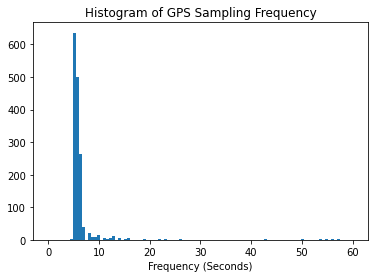

In [260]:
#  Histogram of heartbeat frequencies
plt.hist(
    sample_5004.time.diff() / np.timedelta64(1, 's'),
    range=[0, 60], 
    bins=100
)
plt.title('Histogram of GPS Sampling Frequency')
plt.xlabel('Frequency (Seconds)')

In [256]:
#  Histogram of GPS location frequencies
plt.hist(
    trakm8_data_df[trakm8_data_df['Message'] == 'GPS Periodic'].Time_adjusted.diff() / np.timedelta64(1, 's'),
    range=[0, 100], 
    bins=100
)
plt.title('Histogram of GPS Time Intervals')
plt.xlabel('Time Interval (Seconds)')

NameError: name 'trakm8_data_df' is not defined

In [191]:
# Speeding
trakm8_data_df[trakm8_data_df['Message'] == 'Speeding Ended']

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
403,Speeding Ended,357788108263491,21/07/2021 16:00:31 (BST),50.959874,-1.425760,80.0,80.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:00:31
405,Speeding Ended,357788108263491,21/07/2021 16:01:14 (BST),50.957739,-1.447338,91.0,91.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:01:14
411,Speeding Ended,357788108263491,21/07/2021 16:03:10 (BST),50.940173,-1.473303,74.0,74.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:03:10
412,Speeding Ended,357788108263491,21/07/2021 16:03:25 (BST),50.935858,-1.473254,72.0,72.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 16:03:25
468,Speeding Ended,357788108263491,21/07/2021 19:43:43 (BST),50.943521,-1.474988,89.0,89.0,70.0,WAUZZZ8P0BA14XXXX,2021-07-21 19:43:43
...,...,...,...,...,...,...,...,...,...,...
37300,Speeding Ended,357788108159467,28/07/2021 18:02:44 (BST),50.920215,-1.590156,71.0,71.0,70.0,SALFA2AB0AH18XXXX,2021-07-28 18:02:44
37307,Speeding Ended,357788108159467,28/07/2021 18:05:59 (BST),50.946375,-1.514161,81.0,81.0,70.0,SALFA2AB0AH18XXXX,2021-07-28 18:05:59
37313,Speeding Ended,357788108159467,28/07/2021 18:08:16 (BST),50.955848,-1.454610,78.0,78.0,70.0,SALFA2AB0AH18XXXX,2021-07-28 18:08:16
37560,Speeding Ended,357788108159467,30/07/2021 10:33:12 (BST),50.855904,-1.130621,72.0,72.0,70.0,SALFA2AB0AH18XXXX,2021-07-30 10:33:12


In [214]:
trakm8_data_df[trakm8_data_df['Message'] == 'Speeding Ended']['Threshold'].value_counts()

70.0    896
Name: Threshold, dtype: int64

Text(0.5, 0, 'Speed (MPH)')

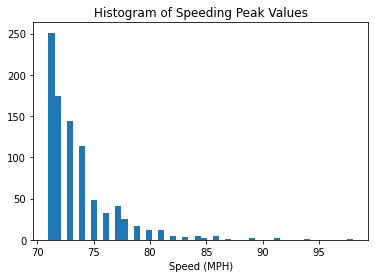

In [201]:
#  Histogram of Overspeedings
plt.hist(
    trakm8_data_df[trakm8_data_df['Message'] == 'Speeding Ended']['Peak Value'],
    # range=[0, 100], 
    bins=50
)
plt.title('Histogram of Speeding Peak Values')
plt.xlabel('Speed (MPH)')

In [204]:
# Idling
trakm8_data_df[trakm8_data_df['Message'].str.contains("Idle")]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
75,Idle Start,357788108263491,19/07/2021 14:27:59 (BST),50.917810,-1.315235,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:27:59
77,Excessive Idle,357788108263491,19/07/2021 14:28:59 (BST),50.917839,-1.315081,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:28:59
78,Idle Ongoing,357788108263491,19/07/2021 14:28:59 (BST),50.917839,-1.315081,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:28:59
80,Idle Ongoing,357788108263491,19/07/2021 14:29:59 (BST),50.917842,-1.314984,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:29:59
82,Idle Ongoing,357788108263491,19/07/2021 14:30:59 (BST),50.917788,-1.314922,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:30:59
84,Idle Ongoing,357788108263491,19/07/2021 14:31:59 (BST),50.917732,-1.314935,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:31:59
85,Idle End,357788108263491,19/07/2021 14:32:04 (BST),50.917745,-1.314922,1.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-19 14:32:04
646,Idle Start,357788108263491,22/07/2021 16:00:27 (BST),50.868697,-1.281009,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-22 16:00:27
648,Excessive Idle,357788108263491,22/07/2021 16:01:27 (BST),50.868691,-1.281003,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-22 16:01:27
649,Idle Ongoing,357788108263491,22/07/2021 16:01:27 (BST),50.868691,-1.281003,0.0,NaN,NaN,WAUZZZ8P0BA14XXXX,2021-07-22 16:01:27


In [213]:
# Device status
trakm8_data_df[trakm8_data_df['Message'].isin(trakm8_data_df['Message'].value_counts()[-7:].index)]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
13822,Power Restored,358636084505667,20/07/2021 09:23:49,0.000000,0.000000,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 09:23:49
13824,Device Removed,358636084505667,20/07/2021 10:25:21 (BST),53.773666,-1.529307,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:21
13827,Power Lost,358636084505667,20/07/2021 10:25:25 (BST),53.773657,-1.529305,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:25
13830,Power Restored,358636084505667,20/07/2021 10:25:55 (BST),53.773650,-1.529307,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:55
13831,Device Inserted,358636084505667,20/07/2021 10:25:55 (BST),53.773650,-1.529307,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:25:55
13833,Device Removed,358636084505667,20/07/2021 10:27:12 (BST),53.773638,-1.529280,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:12
13834,Power Lost,358636084505667,20/07/2021 10:27:17 (BST),53.773623,-1.529277,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:17
13836,Power Restored,358636084505667,20/07/2021 10:27:37 (BST),53.773621,-1.529248,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:37
13837,Device Inserted,358636084505667,20/07/2021 10:27:37 (BST),53.773621,-1.529248,1.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 10:27:37
13844,VIN,358636084505667,20/07/2021 16:33:50 (BST),53.773287,-1.529247,0.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-20 16:33:50


In [224]:
# Harsh events
trakm8_data_df[trakm8_data_df['Message'].isin(['Harsh Braking', 'Harsh Acceleration', 'Harsh Right Cornering', 'Harsh Left Cornering'])]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
136,Harsh Left Cornering,357788108263491,19/07/2021 16:00:37 (BST),50.869705,-1.254843,34.0,46.0,45.0,WAUZZZ8P0BA14XXXX,2021-07-19 16:00:37
183,Harsh Acceleration,357788108263491,19/07/2021 20:07:36 (BST),50.955491,-1.371604,19.0,28.2,25.0,WAUZZZ8P0BA14XXXX,2021-07-19 20:07:36
239,Harsh Acceleration,357788108263491,20/07/2021 16:50:32 (BST),50.862501,-1.254019,21.0,40.6,25.0,WAUZZZ8P0BA14XXXX,2021-07-20 16:50:32
338,Harsh Acceleration,357788108263491,20/07/2021 20:57:33 (BST),50.915378,-1.357788,36.0,27.6,25.0,WAUZZZ8P0BA14XXXX,2021-07-20 20:57:33
378,Harsh Acceleration,357788108263491,21/07/2021 15:46:38 (BST),50.862648,-1.254062,19.0,40.8,25.0,WAUZZZ8P0BA14XXXX,2021-07-21 15:46:38
...,...,...,...,...,...,...,...,...,...,...
35589,Harsh Braking,352255060717406,06/08/2021 18:51:43 (BST),51.788044,-0.622476,34.0,32.6,30.0,WF0FXXWPCFJP2XXXX,2021-08-06 18:51:43
35598,Harsh Braking,352255060717406,06/08/2021 18:53:54 (BST),51.797178,-0.605062,26.0,46.8,30.0,WF0FXXWPCFJP2XXXX,2021-08-06 18:53:54
36787,Harsh Braking,357788108159467,26/07/2021 16:31:11 (BST),50.872260,-1.271881,21.0,37.6,30.0,SALFA2AB0AH18XXXX,2021-07-26 16:31:11
36810,Harsh Braking,357788108159467,26/07/2021 16:44:55 (BST),50.948425,-1.368830,21.0,33.1,30.0,SALFA2AB0AH18XXXX,2021-07-26 16:44:55


In [225]:
trakm8_data_df[trakm8_data_df['Message'].isin(['Harsh Braking', 'Harsh Acceleration', 'Harsh Right Cornering', 'Harsh Left Cornering'])]['Threshold'].value_counts()

30.0    185
25.0    149
45.0    100
Name: Threshold, dtype: int64

In [229]:
# RPM
trakm8_data_df[trakm8_data_df['Message'].isin(['RPM Over Threshold'])]

,Message,IMEI,Time,Latitude,Longitude,Speed (MPH),Peak Value,Threshold,VIN,Time_adjusted
15397,RPM Over Threshold,358636084505667,07/08/2021 15:49:42 (BST),53.776032,-1.581325,40.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-08-07 15:49:42
15409,RPM Over Threshold,358636084505667,07/08/2021 15:54:29 (BST),53.798130,-1.561857,36.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-08-07 15:54:29
16064,RPM Over Threshold,358636084505667,27/07/2021 09:52:03 (BST),52.622376,-1.800500,33.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 09:52:03
16065,RPM Over Threshold,358636084505667,27/07/2021 09:52:09 (BST),52.621346,-1.800418,53.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 09:52:09
16095,RPM Over Threshold,358636084505667,27/07/2021 10:00:16 (BST),52.528534,-1.722835,49.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 10:00:16
16104,RPM Over Threshold,358636084505667,27/07/2021 10:03:40 (BST),52.511397,-1.709670,14.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 10:03:40
16168,RPM Over Threshold,358636084505667,27/07/2021 16:58:15 (BST),52.539851,-1.729934,55.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 16:58:15
16170,RPM Over Threshold,358636084505667,27/07/2021 16:58:28 (BST),52.543544,-1.729719,71.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 16:58:28
16202,RPM Over Threshold,358636084505667,27/07/2021 17:14:54 (BST),52.668104,-2.001177,38.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 17:14:54
16203,RPM Over Threshold,358636084505667,27/07/2021 17:14:59 (BST),52.668692,-2.002553,57.0,NaN,NaN,WAUZZZ8V9KA10XXXX,2021-07-27 17:14:59


In [230]:
# Uniform sampling per vehicle/device